# Genome IGR Analysis Report 
## Purpose
This sheet serves to compile the results of several analytical programs run to analyze the output of a selected IGR into one easily viewable location. 

The information compiled includes:
* Number of hits
* Structure predicted by R-scape
* Structure predicted by CMfinder
* Possible sub-structures highlighted by CMfinder
* Gene Association
* Examples of specific gene context

### Necessary code imports and Preparation

In [1]:
from Bio import AlignIO, SeqIO
import random
import subprocess
import os
import pandas as pd
import glob
import re
import tarfile
import ipywidgets


%cd /home/jovyan/work
from src.data.genome_context import get_all_images, run_rscape, tar_subdir_members, build_target_coords

/home/jovyan/work


## Step 1 
Compress the results of the Infernal Step1 analysis on the computational cluster using the command:

`tar czvf Chlamydia_psittaci_GCA_000417565.1_selection_0.5_2.0_-2.0_infernal_step1.tar.gz Chlamydia_psittaci_GCA_000417565.1_selection_0.5_2.0_-2.0_infernal_step1/`

## Step 2
Place the downloaded tar.gz file in data/import directory of the DIMPL's file architecture. 

## Step 3 
Change the variable `import_tar_name` and `step_name` below to reflect the data being imported.

In [2]:
# Change the variables here to reflect data being imported
import_tar_name = "data/import/Francisella_tularensis_GCA_000008985.1_selection_0.5_2.0_-2.0_infernal_step1.tar.gz"
assembly_acc = "GCA_000008985.1"
selection_name = "selection_0.5_2.0_-2.0"
step_name = 'infernal_step1'

# Unpack the files 
untar_dir = "data/genomes/{}/{}".format(assembly_acc, selection_name)        
with tarfile.open(import_tar_name, "r:gz") as tar:
    tar.extractall(path=untar_dir, members=tar_subdir_members(tar, import_tar_name))

### Collect all the potential motifs in the imported directory and generate selection dropdown

In [3]:
data_dir="{}/{}".format(untar_dir, step_name)
tblout_files = glob.glob("{}/*/*.tblout".format(data_dir))        
motif_list = list(file.split('/')[-1][:-10] for file in tblout_files)
motif_dropdown = ipywidgets.Dropdown(options=motif_list, description="Motif Name",  layout={'width': 'max-content'})
motif_dropdown

Dropdown(description='Motif Name', layout=Layout(width='max-content'), options=('AJ749949_1041004-1041510_igr'…

## Step 4

After selecting an IGR from the dropdown above, run all cells starting at this codeblock to generate the analysis data.

In [4]:
# Saves the next motif in the list of motifs to motif_name
motif_name=motif_dropdown.value
outdir="{}/{}".format(data_dir,motif_name)
sto_filename = "{}/{}.cm.align.sto".format(outdir, motif_name)
dedupe_filename = "{}/{}.dedupe.fasta".format(outdir, motif_name)
sample_filename = "{}/{}.sample.fasta".format(outdir, motif_name)
results_filename ="{}/{}.cm.tblout".format(outdir, motif_name) 

# Read in the results from the .tblout file
results_df = pd.read_csv(results_filename, skiprows=2, skipfooter=10, sep='\s+', engine='python', header=None, 
                         names=['target_name', 'target_accession', 'query_name', 'query_accession', 'mdl', 'mdl_from', 'mdl_to', 
                                'seq_from', 'seq_to', 'strand', 'trunc', 'pass', 'gc', 'bias', 'score', 'e_value', 'inc','description'])
# Correct coordinates taking IGR database into account
results_df['target_coords'] = results_df.apply(lambda row: build_target_coords(row['target_name'], row['seq_from'], row['seq_to']), axis=1)
results_df.drop(columns=['target_accession', 'query_accession', 'inc', 'description', 'query_name'], inplace=True)

# Remove duplicate entries from the database
dedupe_fasta = list(SeqIO.parse(dedupe_filename, 'fasta'))
dedupe_id_list = [(record.id) for record in dedupe_fasta]
deduped_results_df = results_df[results_df['target_coords'].isin(dedupe_id_list)]

# Output results
print("Results for: {}".format(motif_name))
print("Number of Unique Hits: {}".format(len(dedupe_id_list)))

# Display up to 100 rows
with pd.option_context('display.max_rows', 100):
    display(deduped_results_df[['e_value', 'target_coords', 'gc', 'bias', 'score', 'strand', ]])

Results for: AJ749949_1041004-1041510_igr
Number of Unique Hits: 21


,e_value,target_coords,gc,bias,score,strand
0,2.400000e-138,NC_006570.2/1041004-1041509,0.26,32.4,475.6,+
41,1.100000e-137,NC_016933.2/1116853-1117358,0.26,32.8,473.4,+
47,2.800000e-136,NZ_AUXB01000002.1/87280-87785,0.26,32.8,468.8,+
219,2.400000e-130,NC_017450.1/963040-963538,0.26,32.9,449.3,+
220,2.300000e-129,NC_008601.1/965224-965743,0.26,32.9,446.1,+
224,2.600000e-129,NZ_DS995363.1/558307-558824,0.27,31.2,446.0,+
225,1.200000e-127,NZ_CP016635.1/970401-970914,0.27,32.0,440.4,+
226,1.600000e-122,NZ_DS264589.1/544223-544758,0.25,34.7,423.7,+
231,7.700000e-116,NZ_LVKY01000031.1/19824-20257,0.28,23.5,401.8,+
237,2.700000e-93,NZ_CP018093.1/1191611-1192144,0.28,29.0,327.8,+


## R-scape Structure Prediction from Co-variation

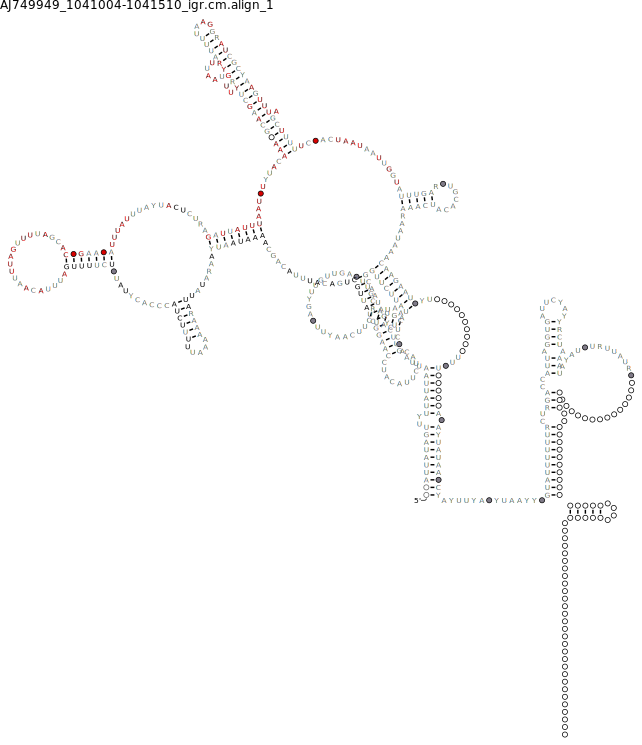

In [5]:
run_rscape(outdir, sto_filename, fold=True, output=False)

### RNAcode Analysis for Possible Protein Coding Regions

In [6]:
clustal_filename = "{}/{}/{}.sample.clustal".format(data_dir,motif_name, motif_name) 

sample_fasta = list(SeqIO.parse(sample_filename, 'fasta'))
sample_id_list = [record.id for record in sample_fasta]
sto_records = list(SeqIO.parse(sto_filename, 'stockholm'))
sampled_sto_records = [record for record in sto_records if record.id in sample_id_list]

alignment = sampled_sto_records[:200]

with open(clustal_filename, 'w') as clustal_file:
    SeqIO.write(alignment, clustal_file, "clustal")
    
output = subprocess.run(['RNAcode', clustal_filename], capture_output=True)

print(output.stdout.decode())
print(output.stderr.decode())


 HSS # Frame Length  From    To        Name       Start         End    Score        P
     0    -1     14   152   165NC_006570.2/1041004-1041509         454         495     3.36    0.230
     1    -3      4   150   153NC_006570.2/1041004-1041509         450         461     1.56    0.966
     2    -3      4    86    89NC_006570.2/1041004-1041509         258         269     1.44    0.982
     3    +3      4   150   153NC_006570.2/1041004-1041509         450         461     1.24    0.995
     4    -3      4    37    40NC_006570.2/1041004-1041509         111         122     1.17    0.997
     5    -3      4    14    17NC_006570.2/1041004-1041509          42          53     1.05    0.999
     6    +2      7   125   131NC_006570.2/1041004-1041509         374         394     0.92    1.000
     7    +1      6   137   142NC_006570.2/1041004-1041509         409         426     0.89    1.000
     8    +2      4   150   153NC_006570.2/1041004-1041509         449         460     0.76    1.000
    

### CMfinder Motif Discovery

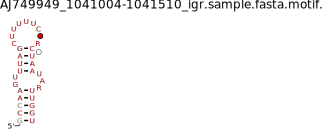

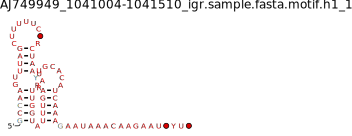

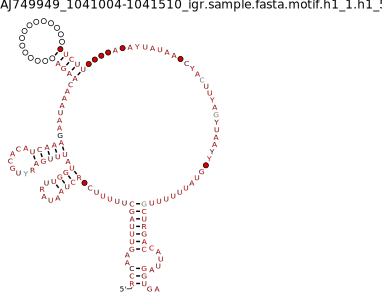

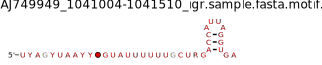

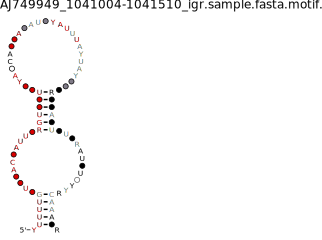

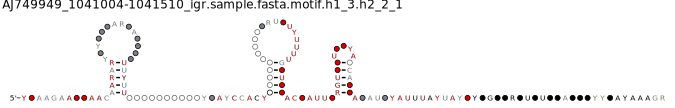

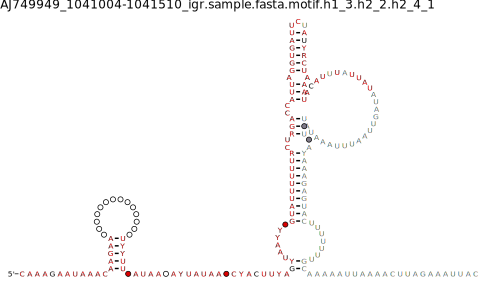

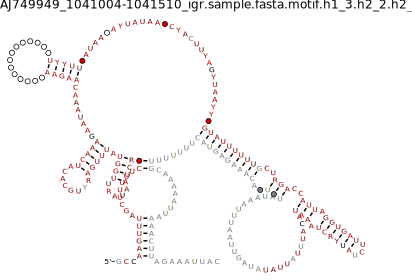

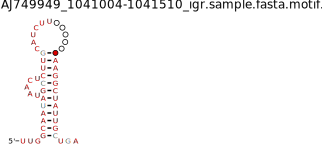

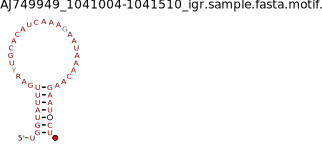

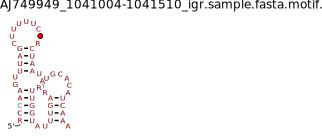

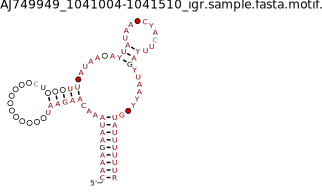

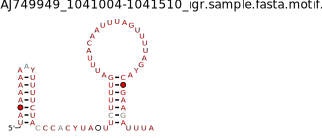

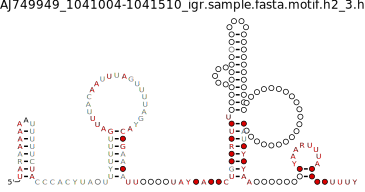

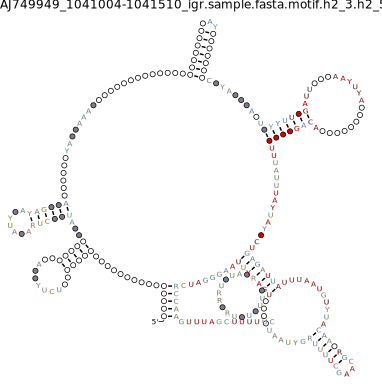

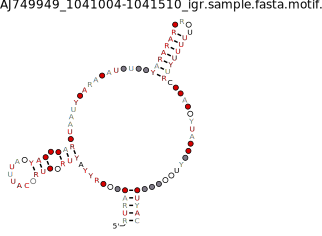

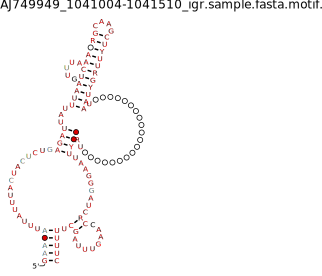

In [7]:
import os

def check_motif(motif):
    for fragment in ['cov', 'dplot', 'power', 'R2R', 'sorted', 'surv', 'temp.gap', 'svg', 'ps']:
        if fragment in motif:
            return False
    return True

motif_files = glob.glob("{}/{}/*motif*".format(data_dir, motif_name))
# Get the list of all the motif portions predicted by cmfinder
cmfinder_motifs = [file[file.rfind('motif')+6:] for file in motif_files]
# Remove duplicates
cmfinder_motifs = list(set(cmfinder_motifs))
# Remove motifs with '.temp.gap'
cmfinder_motifs = [ motif for motif in cmfinder_motifs if check_motif(motif)]

completed_motifs = []

cmfinder_motifs.sort()
for motif in cmfinder_motifs:
    file = "{}/{}.sample.fasta.motif.{}".format(outdir, motif_name, motif)
    if file[-4:] != '.sto':
        os.rename(file, "{}.sto".format(file))
        file = "{}.sto".format(file)
    if file not in completed_motifs:
        run_rscape(outdir, file, fold=False, output=False)
        completed_motifs.append(file)
    
all_files = glob.glob("{}/{}/*".format(data_dir, motif_name))


## Genome Context Images

Match #1
E-value: 2.3999999999999972e-138
%GC: 0.26
Score: 475.6
Genome Assembly: GCF_000008985.1_ASM898v1
Target: NC_006570.2/1041004-1041509
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis; Francisella tularensis subsp. tularensis
Matched Sequence: GGAUUAUAGUUCUUAUUAAUUAAUCUCAUCUUCAAUUUCAGUUUGUUGACUUGCAAUGAUAUUCUUGGCAAUAGUAACUCCUUGCAUCUUACAUCCAAGGCUAUUGCUGACAUUUACAGCAAAAUAAUUAAGAUAUUAGAAAAAAUUUUUCUACCCACCUAUUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAGAUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUGGUUAAUUGAUUUUAAGGGAUCGCCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUGCUAGACCAUUAGGUGAUUCUAUCACUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUCUCACAAAGAGUACUUUUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


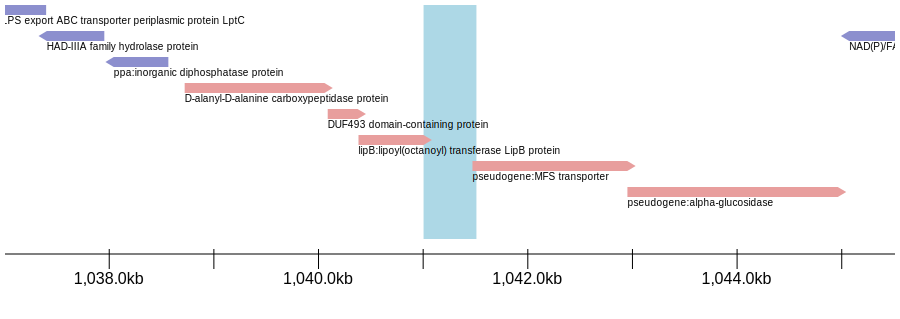

Match #42
E-value: 1.0999999999999989e-137
%GC: 0.26
Score: 473.4
Genome Assembly: GCF_000248415.2_ASM24841v2
Target: NC_016933.2/1116853-1117358
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis; Francisella tularensis subsp. tularensis; Francisella tularensis subsp. tularensis TI0902
Matched Sequence: GGAUUAUAGUUCUUAUUAAUUAAUCUCAUCUUCAAUUUCAGUUUGUUGACUUGCAAUGAUAUUCUUGGCAAUAGUAACUCCUUGCAUCUUACAUCCAAGGCUAUUGCUGACAUUUACAGCAAAAUAAUUAAGAUAUUAGAAAAAAUUUUUCUACCCACCUAUUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAGAUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUGGUUAAUUGAUUUUAAGGGAUCGCCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUGCUAGACCAUUAGGUGAUUCUAUCACUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUCUCAUAAAGAGUACUUUUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


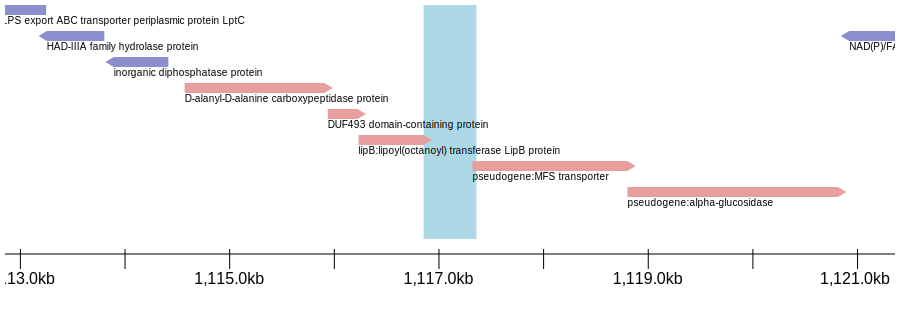

Match #48
E-value: 2.7999999999999963e-136
%GC: 0.26
Score: 468.8
Genome Assembly: GCF_000478845.1_FT_99A
Target: NZ_AUXB01000002.1/87280-87785
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis
Matched Sequence: GGAUUAUAGUUCUUAUUAAUUAAUCUCAUCUUCAAUUUCAGUUUGUUGACUUGCGAUGAUAUUCUUGGCAAUAGUAACUCCUUGCAUCUUACAUCCAAGGCUAUUGCUGACAUUUACAGCAAAAUAAUUAAGAUAUUAGAAAAAAUUUUUCUACCCACCUAUUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAGAUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUGGUUAAUUGAUUUUAAGGGAUCGCCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAAAAUAAACAAGAAUACUAUAAUAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUACUAGACCAUUAGGUGAUUCUAUCACUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUCUCACAAAGAGUACUUUUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


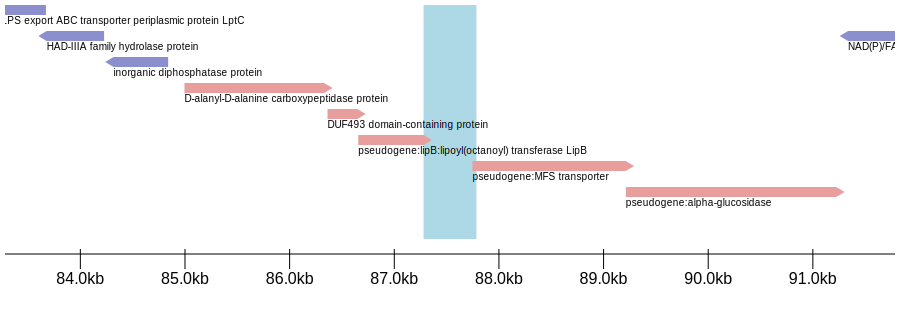

Match #220
E-value: 2.3999999999999996e-130
%GC: 0.26
Score: 449.3
Genome Assembly: GCF_000195535.1_ASM19553v1
Target: NC_017450.1/963040-963538
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis; Francisella tularensis subsp. novicida
Matched Sequence: AUUAUAGUUUUUAUUAAUUAAACUCAUCUUCAAUUUCAGUUUGUUGACUUGCAACGAUAUUCUUGGCAAUAGUAACUCCUUUCAUCUUAAAGGCUAUUGCUGACAUUUACAGCAAAAUAAUUAAGAUAUUAGAAAAAAUUUUUCUACCCCCCUAUUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAGAUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUGGUUAAUUGAUUUUAAGGGAUCGCCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUGCUAGACCAUUAGGUGAUUCCAUCACUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUCUCACAAAGAGUACUUUUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


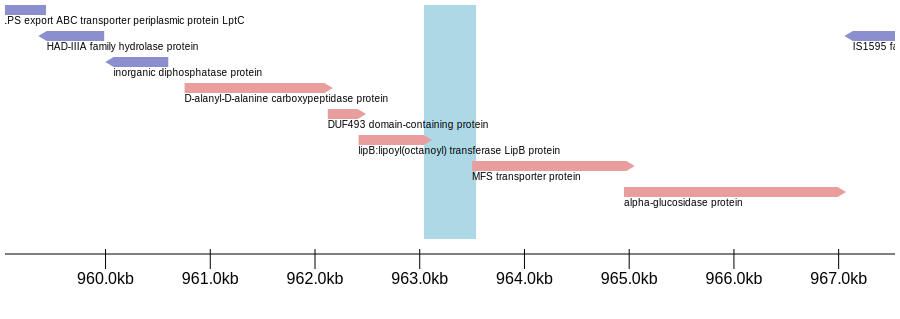

Match #221
E-value: 2.2999999999999996e-129
%GC: 0.26
Score: 446.1
Genome Assembly: GCF_000014645.1_ASM1464v1
Target: NC_008601.1/965224-965743
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis; Francisella tularensis subsp. novicida
Matched Sequence: GGAUUAUAGUUCUUAUUAAUUAAUCUCAUCUUCAAUUUGAGUUUGUUGACUUGCGAUGAUAUUCUUGGCAAUAGUAACUCCUUGCAUCUUACAUCCAAGGCUAUUGCUGACAUUUAUAGCAAAAUAAUCAAGUaauaacaaaagcuUAUUAGAAAAAUUUUUUCUACCCACCUAUUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAGAUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUGGUUAAUUGAUUUUAAGGGAUCGCUAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUGCUAGACCAUUAGGUGAUUCUACCACUAAAUAUAUUUAUUAUAUAGUUAAUUUAAAUAUCUCACAAAGAGUACUUUuUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


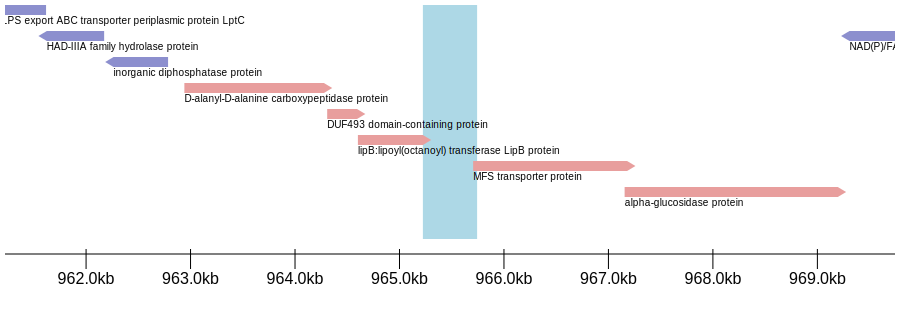

Match #225
E-value: 2.5999999999999972e-129
%GC: 0.27
Score: 446.0
Genome Assembly: GCF_000156415.1_ASM15641v1
Target: NZ_DS995363.1/558307-558824
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis; Francisella tularensis subsp. novicida
Matched Sequence: GGAUUAUAGUUCUUAUUAAUUAAUCUCAUCUUCAAUUUGAGUUUGUUGACUUGCGAUGAUAUUCUUGGCAAUAGUAACUCCUUGCAUCUUACAUCCAAGGCUAUUGCUGACAUUUACAGCAAAAUAAUCAAGUaauaacaaaagcuUAUUAGAAAAAUUUUUUCUACCCACCUAUUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAGAUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUGGUUAAUUGAUUUUAAGGGAUCGCCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUGCUAGACCAUUAGGUGAUUCCAUCACUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUCUCACAAAGAGUACUUUuUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


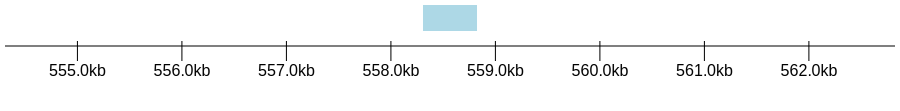

Match #226
E-value: 1.1999999999999985e-127
%GC: 0.27
Score: 440.4
Genome Assembly: GCF_001865695.1_ASM186569v1
Target: NZ_CP016635.1/970401-970914
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis; Francisella tularensis subsp. novicida
Matched Sequence: GGAUUAUAGUUCUUAUUAAUUAAUCUCAUCUUCAAUUUGAGUUUGUUGACUUGCGAUGAUAUUCUUGGCAAUAGUAACUCCUUGCAUCUUAAAGGCUAUUGCUGACAUUUACAGCAAAAUAAUCAAGUaauaacaaaagcuUAUUAGAAAAAUUUUUUCUACCCACCUAUUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAGAUUUAUUUACUACUCUGAGAUUAUUUAAUCUUUACAAAGGCAAGCUUUUGGUUAAUUGAUUUUAAGGGAUCGCCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUGCUAGACCAUUAGGUGAUUCCAUCACUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUCUCACAAAGAGUACUUUUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


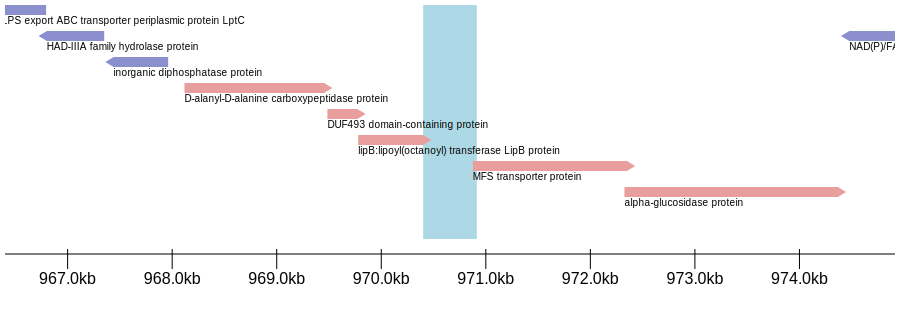

Match #227
E-value: 1.5999999999999985e-122
%GC: 0.25
Score: 423.7
Genome Assembly: GCF_000154265.1_ASM15426v1
Target: NZ_DS264589.1/544223-544758
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis; Francisella tularensis subsp. novicida
Matched Sequence: AUUAUAGUUUUUAUUAAUUAAACUCAUCUUCAAUUUCAGUUUGUUGACUUGCAAUGAUAUUCUUGGCAAGAGUAACUCCUUGCAUCUUACAUCCAAGGCUAUUGCUGACAUUUACAGCAAAAUAAUCAAGAaauaacaaaagcuUAUUAGAAAAAAUUUUUCUACCCACCUAUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAUAUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUAGUUAAUUAAUUgauuugucuaugauuuaugcUUAAGGGAUCACCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAUCUAAUUCGUAUUUUUUGCUAGACCAUUAGGUGAUUCUAUCACUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUCUAACAAAGAGUACUUUUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


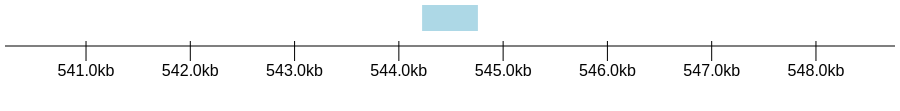

Match #232
E-value: 7.69999999999999e-116
%GC: 0.28
Score: 401.8
Genome Assembly: GCF_001696945.1_FTUL003-SEQ-1-ASM-1
Target: NZ_LVKY01000031.1/19824-20257
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella
Matched Sequence: GGAUUAUAGUUCUUAUUAAUUAAUCUCAUCUUCAAUUUCAGUUUGUUGACUUGCGAUGAUAUUCUUGGCAAUAGUAACUCCUUGCAUCUUACAUCCAAGGCUAUUGCUGACAUUUACAGCAAAAUAAUUAAGAUAUUAGAAAAAAUUUUUCUACCCACCUAUUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAGAUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUGGUUAAUUGAUUUUAAGGGAUCGCCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUAUCCCUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUACUAGACCAUUAGGUGAUUCUAUCACUAAAUACAUAUGUUAUGG


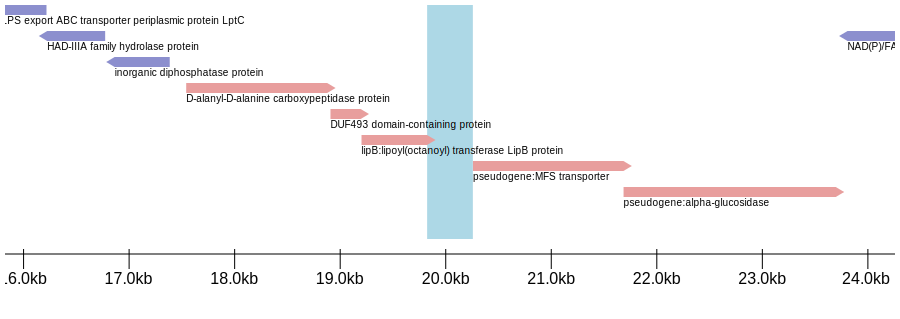

Match #238
E-value: 2.6999999999999993e-93
%GC: 0.28
Score: 327.8
Genome Assembly: GCF_001885235.1_ASM188523v1
Target: NZ_CP018093.1/1191611-1192144
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella hispaniensis
Matched Sequence: AUUAUAGUUUUUAUUAAUUAAUCUCAUCUUCAACUUGAGCUUGUUGAGUUGCAAUGAUAUUcuCUUGGCAAUAGUAACUUCUUGCAUCUUccuaaagACAUCCAAGGCUgcAUUGCUGACAUUUACAGAAAAAUACUCAucaAAAuaacaaaagcuUAUUAUAAAAAACUUUUCUACCCACUUAUUUCUUUUGAUUUACAAUUUAGUUUUAGUACUGAAGAUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGCAAGCUCUUGGCUAAUcaauUGAUUuaucugugguuuaugcUUAAGGGAUCGCCAAGUUUAGCUUUUUCUGCaUAAUAGUUGGUAUUUGAGUUGCACAUCAAAGAAUAAACAAGAAUCUUUUAUAAAUUAUAAGCUACUUCAGUUAACCGGUAUUUUUUGCUGGACCAUUAGGUGAUUCUAUUGCUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUGUCACAAAGAGUACUUUUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


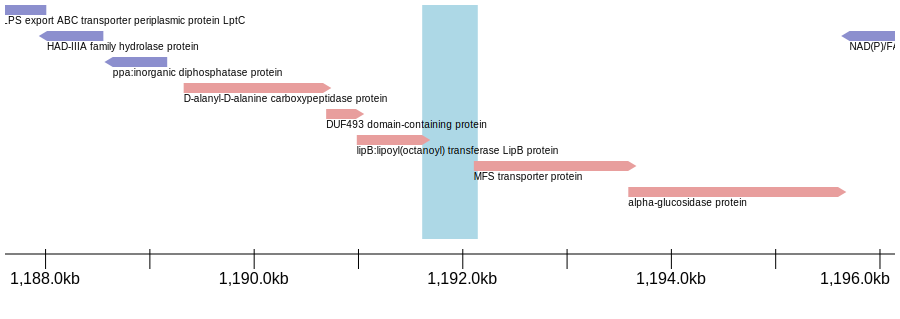

Match #240
E-value: 1.0999999999999995e-73
%GC: 0.25
Score: 263.5
Genome Assembly: GCF_000154185.1_ASM15418v1
Target: NZ_DS264128.1/487426-487858
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis; Francisella tularensis subsp. novicida
Matched Sequence: AAAUGCUGAUAUGAAACACAAAAUAAGGAUUUUUAAGUUGGAUUUCUCUAAAAAUAUcuaAAAUCAAUAGguauaAGAAAAAUCUUAGAUUAACucaACAGCCUUUUUAUUUACUACUCUGAGAUUAUUUAAUGUUUACAAAGGCAAGCUUUUAGUUAAUUAAUUgauuugucuaugauuuaugcUUAAGGGAUCGCCAAGUUUAGCUUUUUCAACUAAUAAUUGGUAUUUGAACUGCACAUCAAAGAAUAAACAAGAAUACUAUAAUAUCCUUUCUUAAUAAUACUAUAAUCCACUUUAGCUAAUUCGUAUUUUUUGCUAGACCAUUAGGUGAUUCUAUCACUAAAUACAUUUAUUAUAUAGUUAAUUUAAAUAUCUCACAAAGAGUACUUUUUUUGCAAAAAUUAAAACUUAGAAAUUACAUAUGUUAUGG


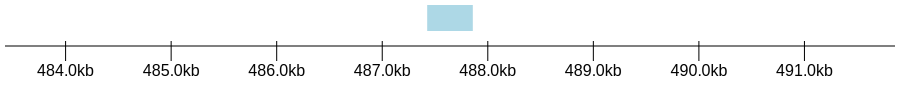

Match #247
E-value: 1.3e-37
%GC: 0.25
Score: 145.2
Genome Assembly: GCF_000742085.1_ASM74208v1
Target: NZ_KN046811.1/1634101-1634406
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Thiotrichales; Francisellaceae; Francisella; Francisella tularensis
Matched Sequence: GGAUUAUAGUUCUUAUUAAUUAAUCUCAUCUUCAAUUUGAGUUUGUUGACUUGCGAUGAUAUUCUUGGCAAUAguauaGUAACUCCUUGCAUCUUACAUCCAAGGCUAUUGCUGACAUUUACAGCAAAAUAAUCAAGAaauaacaaaagcuUAUUAGAAAAAAUUUUUCUACCCACCUAUUCUUUUGAUUUACAAUUUAGUUUUAGCACAGAAUAUUUAUAAGACUGUUGAUUUAAUCUGcaAAUAAAUUUAUGAAUUUUGUAAAAUAUAGAUAUAGUAGAUaUUUAUAUUUUAAUAAUUAUGGAU


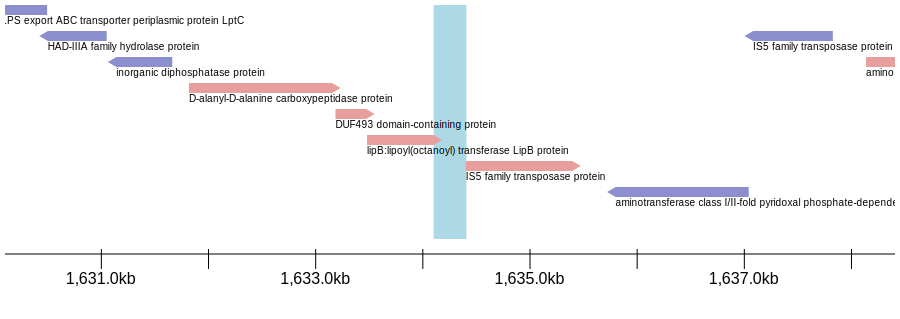

In [8]:
deduped_sto_records = [record for record in sto_records if record.id in dedupe_id_list]
results_csv_filename = "{}/{}_results.csv".format(outdir, motif_name)
if not os.path.exists(results_csv_filename):
    deduped_results_df['lineage']=''
    deduped_results_df['assembly_accession']=''
    deduped_results_df.to_csv(results_csv_filename)
get_all_images(results_csv_filename, deduped_sto_records)